In [1]:
!pip install mitiq --quiet

In [10]:
import warnings

warnings.filterwarnings(action='ignore') # Optional warning filter

In [22]:
from qiskit import IBMQ
IBMQ.save_account('0238b0afc0dc515fe7987b02706791d1719cb89b68befedc125eded0607e6e9e9f26d3eed482f66fdc45fdfceca3aab2edb9519d96b39e9c78040194b86e7858', overwrite=True)

# Section 1: Computing quantum expectation values without error mitigation
## Define the circuit of interest
We first define an arbitrary circuit of interest. For simplicity, in this example we use a two-qubit randomized-benchmarking circuit whose ideal execution is equivalent to the identity operation.

In [12]:
import qiskit
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
from mitiq.interface import convert_to_mitiq, convert_from_mitiq

n_qubits = 2
depth = 20

qiskit_circuit = rb.randomized_benchmarking_seq(
    length_vector=[depth], rb_pattern=[range(n_qubits)], group_gates="0", rand_seed=1,
)[0][0][0]

# Remove Barriers
qiskit_circuit=RemoveBarriers()(qiskit_circuit)
# Remove Measurements
qiskit_circuit=RemoveFinalMeasurements()(qiskit_circuit)

# print(qiskit_circuit)

# Double conversion trick to rename qubit register
circuit = convert_from_mitiq(convert_to_mitiq(qiskit_circuit)[0], "qiskit")

print(f"Randomized benchmarking circuit with {len(circuit)} gates generated.")
print(circuit)

Randomized benchmarking circuit with 211 gates generated.
     ┌───┐┌─────┐┌───┐          ┌───┐┌───┐ ┌───┐ ┌───┐┌───┐     ┌─────┐┌───┐»
q_0: ┤ Y ├┤ Sdg ├┤ H ├───────■──┤ H ├┤ S ├─┤ X ├─┤ H ├┤ S ├──■──┤ Sdg ├┤ H ├»
     ├───┤└┬───┬┘├───┤┌───┐┌─┴─┐├───┤├───┤┌┴───┴┐├───┤└───┘┌─┴─┐└┬───┬┘├───┤»
q_1: ┤ Z ├─┤ S ├─┤ H ├┤ S ├┤ X ├┤ H ├┤ S ├┤ Sdg ├┤ H ├─────┤ X ├─┤ H ├─┤ S ├»
     └───┘ └───┘ └───┘└───┘└───┘└───┘└───┘└─────┘└───┘     └───┘ └───┘ └───┘»
«          ┌───┐┌───┐┌───┐      ┌───┐ ┌───┐     ┌───┐┌───┐┌───┐          ┌───┐»
«q_0: ──■──┤ X ├┤ H ├┤ S ├──■───┤ H ├─┤ S ├──■──┤ X ├┤ H ├┤ S ├───────■──┤ S ├»
«     ┌─┴─┐├───┤├───┤└───┘┌─┴─┐┌┴───┴┐├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤»
«q_1: ┤ X ├┤ X ├┤ H ├─────┤ X ├┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├┤ H ├┤ S ├┤ X ├┤ Y ├»
«     └───┘└───┘└───┘     └───┘└─────┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«     ┌───┐┌───┐          ┌─────┐┌───┐┌───┐                 ┌─────┐┌───┐┌───┐»
«q_0: ┤ H ├┤ S ├───────■──┤ Sdg ├┤ H ├┤ X ├──────────────■──┤ Sdg ├┤ H ├┤

# Execute circuit with noiseless backend

In [13]:
# Set the number of shots 
shots = 10 ** 5

# Initialize ideal backend (classical noiseless simulator)
ideal_backend = qiskit.Aer.get_backend('aer_simulator')

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get count
job = ideal_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Expectation value of A=|00><00|
ideal_value = counts["00"] / shots
ideal_value

1.0

## Executing circuit on a noisy simulated backend

In [28]:
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

# Set the number of shots 
shots = 20000

# Select a noisy backend
# noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get counts
print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = noisy_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Compute expectation value of the observable A=|0><0|
noisy_value = counts["00"] / shots
noisy_value

Executing circuit with 211 gates using 20000 shots.


0.75465

## Section 2: Applying zero-noise extrapolation (ZNE)

### Define an executor function
We rewrite the last code cell of the previous section as a function that we call executor. This function takes as input a Qiskit circuit and returns the final noisy expectation value. The executor is viewed as a blackbox by Mitiq.

Hint: It is usually better, but not necessary, to set optimization_level=0 to avoid automatic circuit optimizations.

In [36]:
def executor(circuit, shots=10 ** 5):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable A=|0><0|
    noisy_value = counts["00"] / shots
    return noisy_value  

In [37]:
noisy_value = executor(circuit)
noisy_value

Executing circuit with 211 gates using 100000 shots.


0.75832

In [32]:
from mitiq import zne

# By default, noise is scaled by locally folding gates at random, and the default extrapolation is Richardson. Scale factor = 3.
zne_value = zne.execute_with_zne(circuit, executor) 

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

Executing circuit with 211 gates using 100000 shots.
Executing circuit with 423 gates using 100000 shots.
Executing circuit with 633 gates using 100000 shots.
Estimation error without Mitiq   : 0.24397000000000002
Estimation error with Mitiq (ZNE): 0.028410000000000046
ZNE reduced the estimation error by 88.4%.


#### Decorator Method

In [34]:
import mitiq

@mitiq.zne.zne_decorator()
def executor(circuit, shots=10 ** 5):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable A=|0><0|
    noisy_value = counts["00"] / shots
    return noisy_value  

In [35]:
noisy_value = executor(circuit)
noisy_value

Executing circuit with 211 gates using 100000 shots.
Executing circuit with 423 gates using 100000 shots.
Executing circuit with 633 gates using 100000 shots.


1.0453900000000003

### Select a noise scaling method

In [33]:
# Choose a unitary folding function
noise_scaling_function = zne.scaling.fold_global

In [38]:
noise_scaled_circuit = noise_scaling_function(circuit, scale_factor=3.5)

print(f"The input circuit has {len(circuit)} gates")
print(f"The scaled circuit has {len(noise_scaled_circuit)} gates")

The input circuit has 211 gates
The scaled circuit has 739 gates


### Select Extrapolation Model

In [54]:
# Examples:

# Richardson extrapolation
# factory = zne.inference.RichardsonFactory(scale_factors = [1, 1.2, 2, 3, 5.5])

# Exponential extrapolation
factory = zne.inference.ExpFactory(scale_factors = [1, 1.5, 2, 3, 3.5], asymptote=0.25)

# Exponential adaptive extrapolation
# factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)

In [55]:
zne_value = zne.execute_with_zne(circuit, executor, scale_noise=noise_scaling_function, factory=factory)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

Executing circuit with 211 gates using 100000 shots.
Executing circuit with 317 gates using 100000 shots.
Executing circuit with 423 gates using 100000 shots.
Executing circuit with 633 gates using 100000 shots.
Executing circuit with 739 gates using 100000 shots.
Estimation error without Mitiq   : 0.24168
Estimation error with Mitiq (ZNE): 0.03625839672298803
ZNE reduced the estimation error by 85.0%.


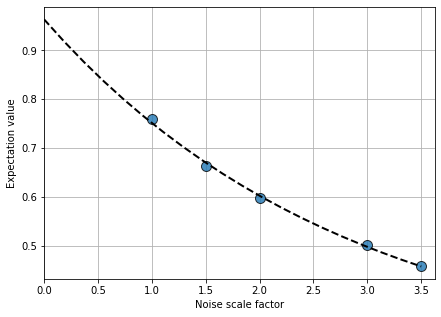

In [56]:
_ = factory.plot_fit()

In [57]:
factory.get_expectation_values()

array([0.75907, 0.66326, 0.59669, 0.5017 , 0.45726])

In [58]:
factory.get_scale_factors()

array([1. , 1.5, 2. , 3. , 3.5])

In [59]:
factory.get_zero_noise_limit()

0.963741603277012

## Section 3: Applying probabilistic error cancellation (PEC)

In [60]:
from mitiq import pec

### Build quasi-probability representation for CNOT gate

For simplicity, we assume that:
- Only CNOT gates are affected by noise;
- The noise is depolarizing.

Even within these assumptions, we still need to know how strong the noise is. A good approximation is the error probability of the CNOT gate.

In [64]:
# Print error probability of CNOT gate
cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=(0, 1))
cnot_error_prob # a very rough approximation of the error acting on a CNOT gate

# print(qiskit.transpile(circuit, backend=noisy_backend))

0.008339674869236618

We now build a quasi-probability representation based on the previous assumptions, i.e., we represent the ideal CNOT as a linear combination of noisy operations:
$$\mathcal G_{\rm CNOT} = \sum_\alpha \eta_\alpha \mathcal O_\alpha, \quad \eta_\alpha \in \mathbb R, \quad \{ \mathcal O_\alpha \} = \text{Noisy implementable operations}.$$

Key idea: Represent a unitary channel by a linear combination of noisy channels which a computer can actually implement.
 

In [68]:
from mitiq.pec.representations.depolarizing import represent_operation_with_global_depolarizing_noise

# Define ideal operation that we aim to represent
cnot_circuit = qiskit.QuantumCircuit(qiskit.QuantumRegister(2, name="q")) 
cnot_circuit.cx(0, 1)

# Build representation
cnot_rep = represent_operation_with_global_depolarizing_noise(cnot_circuit, noise_level=cnot_error_prob)

print(f"Quasi-probability representation with one-norm {cnot_rep.norm :g} generated.")
print(cnot_rep) # full quasi-probability representation of the CNOT gate

import mitiq.pec.representations.optimal.find_optimal_representation 


Quasi-probability representation with one-norm 1.01683 generated.
q_0: ───@───
        │
q_1: ───X─── = 

1.008
q_0: ───@───
        │
q_1: ───X───

-0.001
q_0: ───@───────
        │
q_1: ───X───X───

-0.001
q_0: ───@───────
        │
q_1: ───X───Y───

-0.001
q_0: ───@───────
        │
q_1: ───X───Z───

-0.001
q_0: ───@───X───
        │
q_1: ───X───────

-0.001
q_0: ───@───Y───
        │
q_1: ───X───────

-0.001
q_0: ───@───Z───
        │
q_1: ───X───────

-0.001
q_0: ───@───X───
        │
q_1: ───X───X───

-0.001
q_0: ───@───Y───
        │
q_1: ───X───X───

-0.001
q_0: ───@───Z───
        │
q_1: ───X───X───

-0.001
q_0: ───@───X───
        │
q_1: ───X───Y───

-0.001
q_0: ───@───Y───
        │
q_1: ───X───Y───

-0.001
q_0: ───@───Z───
        │
q_1: ───X───Y───

-0.001
q_0: ───@───X───
        │
q_1: ───X───Z───

-0.001
q_0: ───@───Y───
        │
q_1: ───X───Z───

-0.001
q_0: ───@───Z───
        │
q_1: ───X───Z───


### Run PEC

In [66]:
from functools import partial

# Set number of probabilistically generated circuits
num_samples = 100

# Distribute budget of shots among all circuits
shots_per_circuit = shots // num_samples
pec_executor = partial(executor, shots=shots_per_circuit)

# Run PEC
pec_value = pec.execute_with_pec(
    circuit, pec_executor, representations = [cnot_rep], num_samples=num_samples, random_state=0,
)

unmitigated_error = abs(ideal_value - noisy_value)
pec_error = abs(ideal_value - pec_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (PEC): {pec_error}")

Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 214 gates using 200 shots.


From above, we see that most of the times, we execute the original circuit, but sometimes, we apply one of those noisy operations in the previous section. 

In [67]:
print(f"PEC reduced the estimation error by {(unmitigated_error - pec_error) / unmitigated_error :.1%}.")

PEC reduced the estimation error by 96.3%.


Even under very strong assumptions on the noise model, we are able to get a good improvement.

### Build a noise-agnostic quasi-probability representation for CNOT gate

Instead of a assuming a depolarizing nose model with some given error rate, we now try to use a noise-agnostic representation based on the NEPEC framework introduced in https://arxiv.org/abs/2108.02237 (Section V). More details can be found in the notebook at this [link](https://github.com/unitaryfund/research/blob/main/nepec/noise-agnostic-pec/noise_agnostic_pec.ipynb).

We try to do something like PEC without full knowledge of the noise model.

In [69]:
from mitiq.pec import NoisyOperation, OperationRepresentation


def get_richardson_coefficients(scale_factors):
    """Returns the array of Richardson extrapolation coefficients associated
    to the input array of scale factors."""
    
    # This is based on the Lagrange interpolation formula
    richardson_coeffs = []
    for l in scale_factors:
        coeff = 1.0
        for l_prime in scale_factors:
            if l_prime == l:
                continue
            coeff *= l_prime / (l_prime - l)
        richardson_coeffs.append(coeff)

    return richardson_coeffs

def represent_operation_with_nepec(ideal_operation, scale_factors):
    """Returns the OperationRepresentation contructed by noise scaling and extrapolation."""
    
    coeffs = get_richardson_coefficients(scale_factors)
    
    basis_expansion = {}
    for scale_factor, coeff in zip(scale_factors, coeffs):
        scaled_op = NoisyOperation(noise_scaling_function(ideal_operation, scale_factor))
        basis_expansion[scaled_op] = coeff
    
    return OperationRepresentation(ideal_operation, basis_expansion)

Similar to ZNE, we take a circuit, scale it and then take a linear combination of the results (ideal gate as a linear combination of channels). But we are doing this locally, at the level of an individual gate.

This will work for different levels and types of noise, based on the extrapolation idea. This method is independent from the type of noise.

In [97]:
# scale_factors = [1, 3, 5]  
scale_factors = [1, 100] # Large scale factors reduce the PEC sampling cost.

agn_rep = represent_operation_with_nepec(cnot_circuit, scale_factors)
print(f"NEPEC quasi-probability representation with one-norm {agn_rep.norm :g} generated.")
print(agn_rep)

NEPEC quasi-probability representation with one-norm 1.0202 generated.
q_0: ───@───
        │
q_1: ───X─── = 

1.010
q_0: ───@───
        │
q_1: ───X───

-0.010
q_0: ───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───@───
        │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │
q_1: ───X───X───X───X───X───X───

### Run NEPEC (noise-extended PEC)

In [98]:
nepec_value = pec.execute_with_pec(
    circuit, pec_executor, representations = [agn_rep], num_samples=num_samples, random_state=0,
)

unmitigated_error = abs(ideal_value - noisy_value)
nepec_error = abs(ideal_value - nepec_value)
print(f"Estimation error without Mitiq     : {unmitigated_error}")
print(f"Estimation error with Mitiq (NEPEC): {nepec_error}")

Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 407 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 309 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 211 gates using 200 shots.
Executing circuit with 407 gates using 200 shots.


In [99]:
print(f"NEPEC reduced the estimation error by {(unmitigated_error - nepec_error) / unmitigated_error :.1%}.")

NEPEC reduced the estimation error by 99.8%.
